DATA AUGMENTATION

**A. Target**
1. Move your last code's transformations to Albumentations. Apply ToTensor,     HorizontalFlip, Normalize (at min) + More (for additional points)
2. Please make sure that your test_transforms are simple and only using ToTensor and Normalize
3. Implement GradCam function as a module. 
4. Your final code (notebook file) must use imported functions to implement transformations and GradCam functionality
5. Target Accuracy is 87%

**B. Results**
1. Parameters: 11,173,962
2. Best Training Accuracy in 25 epochs: 95.87%
3. Best Test Accuracy in 25 epochs: 87.66 %
4. Total RF reached: 76*76 at the end of Conv block 4

**C. Analysis**

I have implemented Albumentations transforms for normalization ( by finding norm and std values for entire dataset ), Horizontal flip, Vertical flip, Rotations. This acts as a regularizer and now the model is not overfitting as earlier.


In [1]:
import torch
import torch.optim as optim

from torchsummary import summary
from torch.optim.lr_scheduler import StepLR

import albumentations as A
from collections import Sequence
import numpy as np

from   torch.utils.data import Dataset

import torch.nn.functional as F


In [2]:
!git clone https://github.com/SachinDangayach/TSAI_EVA5.git 
# import sys

Cloning into 'TSAI_EVA5'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 119 (delta 59), reused 91 (delta 31), pack-reused 0
Receiving objects: 100% (119/119), 1.56 MiB | 7.47 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [3]:
# sys.path
# sys.path.append(r'C:\Users\sdangayach162437\Desktop')

In [4]:
# from eva5_copy.dataset import session9_dataset as dataset
# from eva5_copy.models import session8_resnet18_model as models
# from eva5_copy.models import session8_train_model as train
# from eva5_copy.models import session8_test_model as test
# from eva5_copy.utils import session7_utils as utils

from TSAI_EVA5.session9.dataset import session9_dataset as dataset
from TSAI_EVA5.session9.models import session8_resnet18_model as models
from TSAI_EVA5.session9.models import session8_train_model as train
from TSAI_EVA5.session9.models import session8_test_model as test
from TSAI_EVA5.session9.utils import session9_utils as utils

## Extract, Load and Transform Data

In [5]:
# Calculate Ture Mean and STD
norm_mean,norm_std = dataset.cifar10_mean_std() #  (0.49, 0.48, 0.45), (0.25, 0.24, 0.26)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
# Extract Datasets
train_set,test_set = dataset.get_datasets()
# Targets -> ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = train_set.classes

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Get train and test transform
train_transform, test_transform = dataset.get_album_transforms(norm_mean,norm_std)

In [8]:
# transform the data
train_set,test_set = dataset.trasnform_datasets(train_set, test_set, train_transform, test_transform)

# Dataloader Arguments & Test/Train Dataloaders - Load part of ETL
train_loader,test_loader = dataset.get_dataloaders(train_set,test_set)

CUDA Available? True


### Data Exploration

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying 10 images


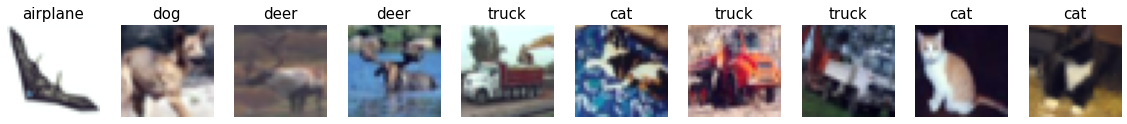

In [9]:
# Explore sample images
utils.show_sample_images(train_loader, classes, .5, .25, num_of_images = 10)

## Import Model and show model summary

In [10]:
# Model summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = models.ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

## Train and Test Model

In [11]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train.train(model, device, train_loader, optimizer, epoch, train_losses, train_acc)
    scheduler.step()
    test.test(model, device, test_loader, test_losses, test_acc)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.6026849746704102 Batch_id=390 Train Accuracy=32.05: 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.4896, Test Accuracy: 4397/10000 (43.97%)

EPOCH: 1


Loss=1.3360753059387207 Batch_id=390 Train Accuracy=48.31: 100%|██████████| 391/391 [01:04<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.2607, Test Accuracy: 5329/10000 (53.29%)

EPOCH: 2


Loss=1.1313824653625488 Batch_id=390 Train Accuracy=57.06: 100%|██████████| 391/391 [01:04<00:00,  6.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.0733, Test Accuracy: 6148/10000 (61.48%)

EPOCH: 3


Loss=0.9026228189468384 Batch_id=390 Train Accuracy=63.84: 100%|██████████| 391/391 [01:04<00:00,  6.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9240, Test Accuracy: 6727/10000 (67.27%)

EPOCH: 4


Loss=0.794493556022644 Batch_id=390 Train Accuracy=68.23: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8083, Test Accuracy: 7111/10000 (71.11%)

EPOCH: 5


Loss=0.7766557931900024 Batch_id=390 Train Accuracy=71.50: 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7780, Test Accuracy: 7282/10000 (72.82%)

EPOCH: 6


Loss=0.6497501134872437 Batch_id=390 Train Accuracy=74.74: 100%|██████████| 391/391 [01:04<00:00,  6.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7021, Test Accuracy: 7527/10000 (75.27%)

EPOCH: 7


Loss=0.8250043988227844 Batch_id=390 Train Accuracy=77.01: 100%|██████████| 391/391 [01:04<00:00,  6.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6376, Test Accuracy: 7754/10000 (77.54%)

EPOCH: 8


Loss=0.574586808681488 Batch_id=390 Train Accuracy=79.73: 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6328, Test Accuracy: 7840/10000 (78.40%)

EPOCH: 9


Loss=0.7086988687515259 Batch_id=390 Train Accuracy=81.25: 100%|██████████| 391/391 [01:04<00:00,  6.07it/s]



Test set: Average loss: 0.6309, Test Accuracy: 7875/10000 (78.75%)



#  Validation accuracies and Loss change curves

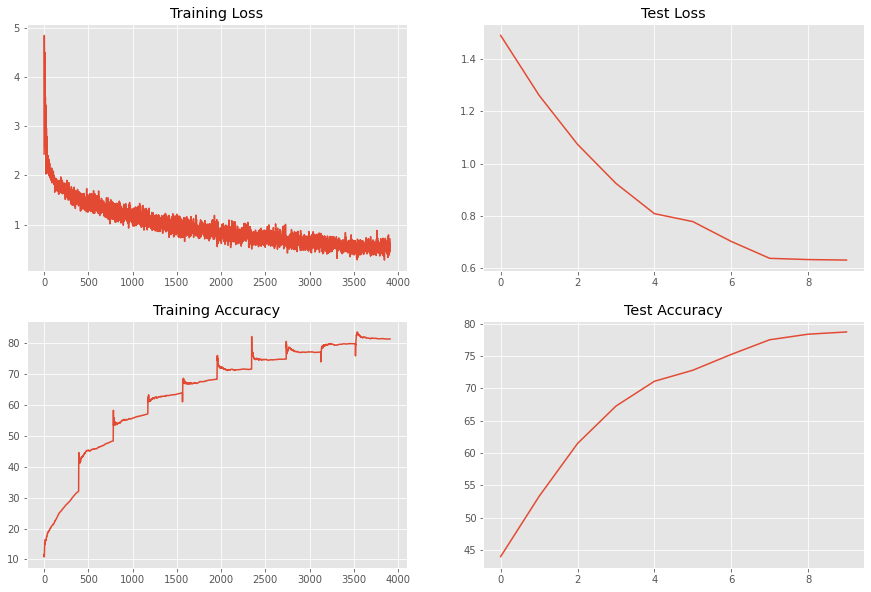

In [12]:
utils.valid_accuracy_loss_plots(train_losses, train_acc, test_losses, test_acc)

## Display misclassified images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


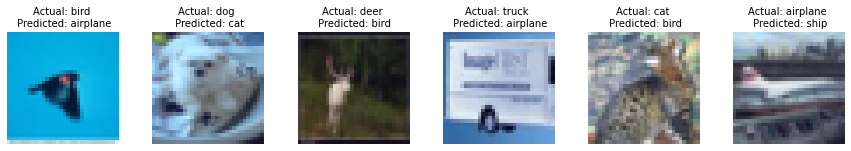

In [13]:
utils.show_misclassified_images(model, classes, test_loader, num_of_images = 5)

# Grad Cam Implementation

In [111]:
import torch
import torch.nn.functional as F


class GradCAM:
    """Calculate GradCAM salinecy map.
    Args:
        input: Input image with shape of (1, 3, H, W)
        class_idx: Class index for calculating GradCAM.
            If not specified, the class index that makes the highest model prediction score will be used.
    Returns:
        mask: Saliency map of the same spatial dimension with input
        logit: Model output
    """

    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        self._target_layer()

        self.gradients = dict()
        self.activations = dict()

        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]

        def forward_hook(module, input, output):
            self.activations['value'] = output

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)
    
    def _target_layer(self):
        layer_num = int(self.layer_name.lstrip('layer'))
        if layer_num == 1:
            self.target_layer = self.model.layer1
        elif layer_num == 2:
            self.target_layer = self.model.layer2
        elif layer_num == 3:
            self.target_layer = self.model.layer3
        elif layer_num == 4:
            self.target_layer = self.model.layer4

    def saliency_map_size(self, *input_size):
        device = next(self.model.parameters()).device
        self.model(torch.zeros(1, 3, *input_size, device=device))
        return self.activations['value'].shape[2:]

    def forward(self, input, class_idx=None, retain_graph=False):
        b, c, h, w = input.size()

        logit = self.model(input)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()

        self.model.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value']
        activations = self.activations['value']
        b, k, u, v = gradients.size()

        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data

        return saliency_map, logit

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)

In [112]:
class GradCAMPP(GradCAM):
    """Calculate GradCAM++ salinecy map.
    Args:
        input: Input image with shape of (1, 3, H, W)
        class_idx: Class index for calculating GradCAM.
            If not specified, the class index that makes the highest model prediction score will be used.
    Returns:
        mask: saliency map of the same spatial dimension with input
        logit: model output
    """

    def forward(self, input, class_idx=None, retain_graph=False):
        b, c, h, w = input.size()

        logit = self.model(input)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()

        self.model.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value']  # dS/dA
        activations = self.activations['value']  # A
        b, k, u, v = gradients.size()

        alpha_num = gradients.pow(2)
        alpha_denom = alpha_num.mul(2) + activations.mul(gradients.pow(3)).view(b, k, u*v).sum(-1).view(b, k, 1, 1)
        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))

        alpha = alpha_num.div(alpha_denom+1e-7)
        positive_gradients = F.relu(score.exp() * gradients)  # ReLU(dY/dA) == ReLU(exp(S)*dS/dA))
        weights = (alpha * positive_gradients).view(b, k, u*v).sum(-1).view(b, k, 1, 1)

        saliency_map = (weights * activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map-saliency_map_min).div(saliency_map_max-saliency_map_min).data

        return saliency_map, logit

In [113]:
def to_numpy(tensor):
    """Convert 3-D torch tensor to a 3-D numpy array.
    Args:
        tensor: Tensor to be converted.
    """
    return np.transpose(tensor.clone().numpy(), (1, 2, 0))

def unnormalize(image, mean, std, out_type='array'):
    """Un-normalize a given image.
    
    Args:
        image: A 3-D ndarray or 3-D tensor.
            If tensor, it should be in CPU.
        mean: Mean value. It can be a single value or
            a tuple with 3 values (one for each channel).
        std: Standard deviation value. It can be a single value or
            a tuple with 3 values (one for each channel).
        out_type: Out type of the normalized image.
            If `array` then ndarray is returned else if
            `tensor` then torch tensor is returned.
    """

    if type(image) == torch.Tensor:
        image = np.transpose(image.clone().numpy(), (1, 2, 0))
    
    normal_image = image * std + mean
    if out_type == 'tensor':
        return torch.Tensor(np.transpose(normal_image, (2, 0, 1)))
    elif out_type == 'array':
        return normal_image
    return None  # No valid value given

In [114]:
import cv2
import torch

import matplotlib.pyplot as plt

# from .gradcam import GradCAM
# from .gradcam_pp import GradCAMPP
# from data.utils import to_numpy, unnormalize


def visualize_cam(mask, img, alpha=1.0):
    """Make heatmap from mask and synthesize GradCAM result image using heatmap and img.
    Args:
        mask (torch.tensor): mask shape of (1, 1, H, W) and each element has value in range [0, 1]
        img (torch.tensor): img shape of (1, 3, H, W) and each pixel value is in range [0, 1]
    Returns:
        heatmap (torch.tensor): heatmap img shape of (3, H, W)
        result (torch.tensor): synthesized GradCAM result of same shape with heatmap.
    """

    heatmap = (255 * mask.squeeze()).type(torch.uint8).cpu().numpy()
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b]) * alpha

    result = heatmap + img.cpu()
    result = result.div(result.max()).squeeze()

    return heatmap, result


class GradCAMView:

    def __init__(self, model, layers, device, mean, std):
        """Instantiate GradCAM and GradCAM++.
        Args:
            model: Trained model.
            layers: List of layers to show GradCAM on.
            device: GPU or CPU.
            mean: Mean of the dataset.
            std: Standard Deviation of the dataset.
        """
        self.model = model
        self.layers = layers
        self.device = device
        self.mean = mean
        self.std = std

        self._gradcam()
        self._gradcam_pp()

        print('Mode set to GradCAM.')
        self.grad = self.gradcam.copy()

        self.views = []

    def _gradcam(self):
        """ Initialize GradCAM instance. """
        self.gradcam = {}
        for layer in self.layers:
            self.gradcam[layer] = GradCAM(self.model, layer)
    
    def _gradcam_pp(self):
        """ Initialize GradCAM++ instance. """
        self.gradcam_pp = {}
        for layer in self.layers:
            self.gradcam_pp[layer] = GradCAMPP(self.model, layer)
    
    def switch_mode(self):
        if self.grad == self.gradcam:
            print('Mode switched to GradCAM++.')
            self.grad = self.gradcam_pp.copy()
        else:
            print('Mode switched to GradCAM.')
            self.grad = self.gradcam.copy()
    
    def _cam_image(self, norm_image):
        """Get CAM for an image.
        Args:
            norm_image: Normalized image. Should be of type
                torch.Tensor
        
        Returns:
            Dictionary containing unnormalized image, heatmap and CAM result.
        """
        norm_image_cuda = norm_image.clone().unsqueeze_(0).to(self.device)
        heatmap, result = {}, {}
        for layer, gc in self.gradcam.items():
            mask, _ = gc(norm_image_cuda)
            cam_heatmap, cam_result = visualize_cam(
                mask,
                unnormalize(norm_image, self.mean, self.std, out_type='tensor').clone().unsqueeze_(0).to(self.device)
            )
            heatmap[layer], result[layer] = to_numpy(cam_heatmap), to_numpy(cam_result)
        return {
            'image': unnormalize(norm_image, self.mean, self.std),
            'heatmap': heatmap,
            'result': result
        }
    
    def _plot_view(self, view, fig, row_num, ncols, metric):
        """Plot a CAM view.
        Args:
            view: Dictionary containing image, heatmap and result.
            fig: Matplotlib figure instance.
            row_num: Row number of the subplot.
            ncols: Total number of columns in the subplot.
            metric: Can be one of ['heatmap', 'result'].
        """
        sub = fig.add_subplot(row_num, ncols, 1)
        sub.axis('off')
        plt.imshow(view['image'])
        sub.set_title(f'{metric.title()}:')
        for idx, layer in enumerate(self.layers):
            sub = fig.add_subplot(row_num, ncols, idx + 2)
            sub.axis('off')
            plt.imshow(view[metric][layer])
            sub.set_title(layer)
    
    def cam(self, norm_image_list):
        """Get CAM for a list of images.
        Args:
            norm_image_list: List of normalized images. Each image
                should be of type torch.Tensor
        """
        for norm_image in norm_image_list:
            self.views.append(self._cam_image(norm_image))
    
    def plot(self, plot_path):
        """Plot heatmap and CAM result.
        Args:
            plot_path: Path to save the plot.
        """

        for idx, view in enumerate(self.views):
            # Initialize plot
            fig = plt.figure(figsize=(10, 10))

            # Plot view
            self._plot_view(view, fig, 1, len(self.layers) + 1, 'heatmap')
            self._plot_view(view, fig, 2, len(self.layers) + 1, 'result')
            
            # Set spacing and display
            fig.tight_layout()
            plt.show()

            # Save image
            fig.savefig(f'{plot_path}_{idx + 1}.png', bbox_inches='tight')

            # Clear cache
            plt.clf()
    
    def __call__(self, norm_image_list, plot_path):
        """Get GradCAM for a list of images.
        Args:
            norm_image_list: List of normalized images. Each image
                should be of type torch.Tensor
        """
        self.cam(norm_image_list)
        self.plot(plot_path)

In [123]:
imgs = []
labels = []
preds = []

model = model.to('cpu')

for img, target in test_loader:
  imgs.append( img )
  labels.append( target )
  preds.append( torch.argmax(model(img), dim=1) )

In [124]:
    imgs = torch.cat(imgs, dim=0)
    labels = torch.cat(labels, dim=0)
    preds = torch.cat(preds, dim=0)

    matches = preds.eq(labels)

In [125]:
miss_clas_index = []
correct_class_index = []
for i in range(len(imgs)):
  if not matches[i]:
    miss_clas_index.append(i)
  else:
    correct_class_index.append(i)


In [128]:
f_images = []
for i in range(10):
  f_images.append(imgs[miss_clas_index[i]])

Mode set to GradCAM.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


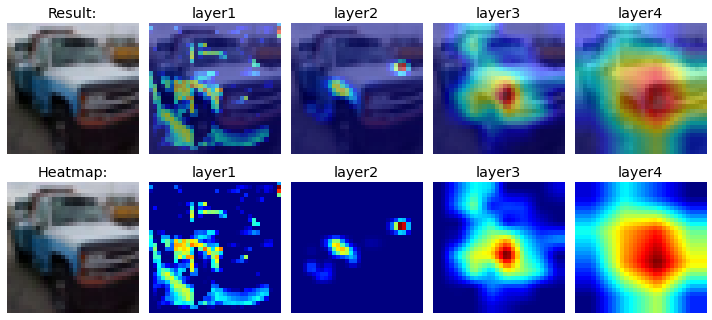

<Figure size 432x288 with 0 Axes>

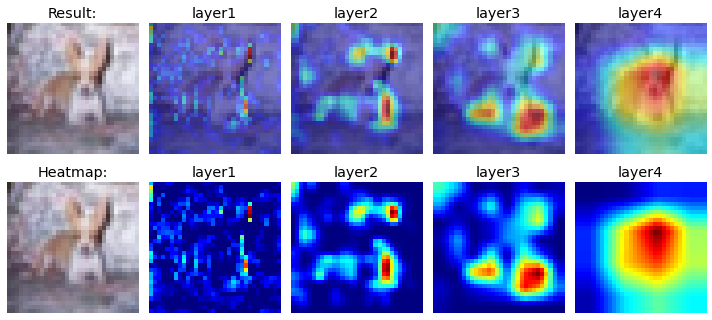

<Figure size 432x288 with 0 Axes>

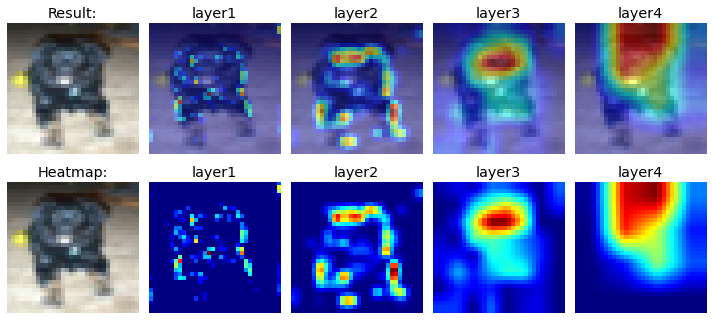

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

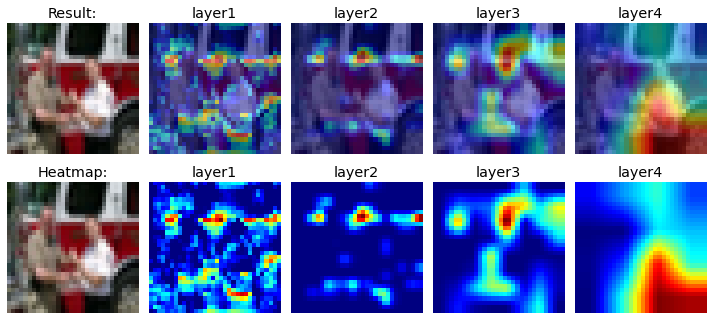

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

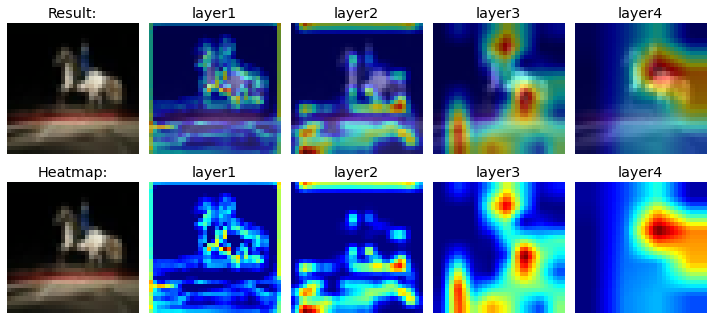

<Figure size 432x288 with 0 Axes>

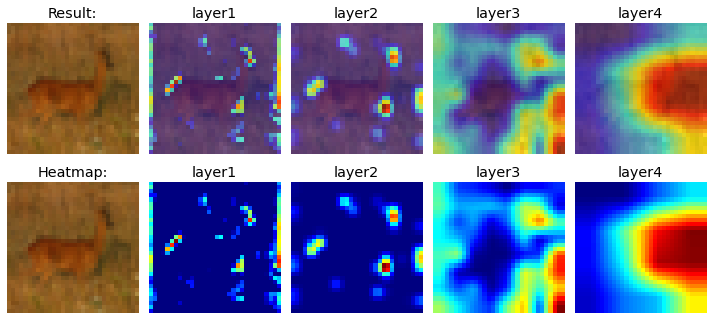

<Figure size 432x288 with 0 Axes>

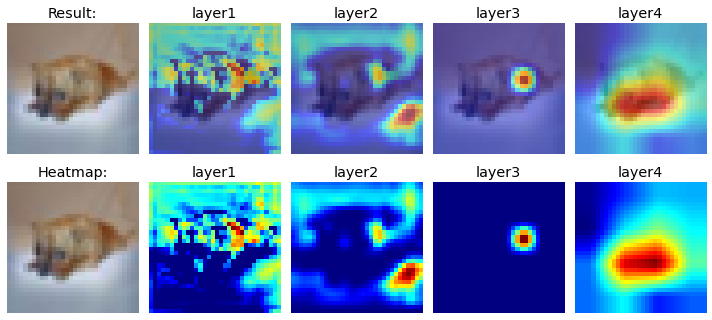

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

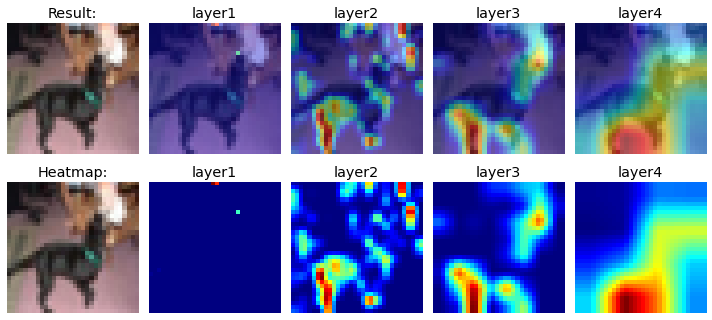

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

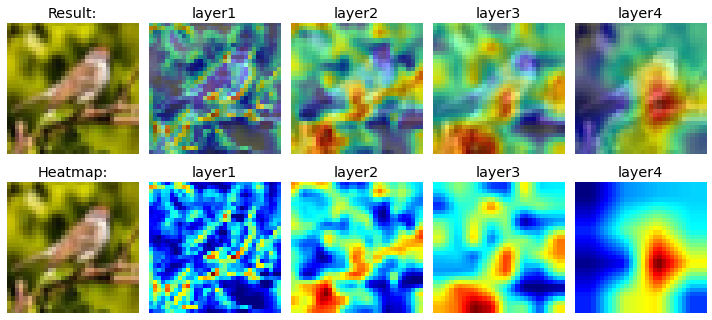

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

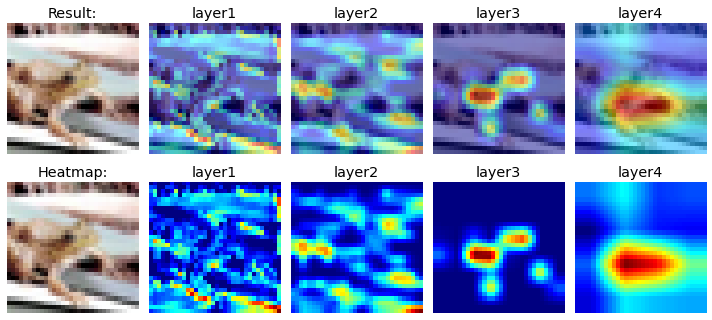

<Figure size 432x288 with 0 Axes>

In [130]:
model = model.to('cuda')
grad_cam = GradCAMView(
    model, ['layer1', 'layer2', 'layer3', 'layer4'],
    device, norm_mean,norm_std 
)

grad_cam(f_images, 'grad_cam')